In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels, **kwargs),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out = self.feature(x)
        return out

In [8]:
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = BasicConv2d(in_channels=inplanes,
                                   out_channels=squeeze_planes, kernel_size=1)
        self.expand1x1 = BasicConv2d(in_channels=squeeze_planes, out_channels=expand1x1_planes,
                                     kernel_size=1)
        self.expand3x3 = BasicConv2d(in_channels=squeeze_planes, out_channels=expand3x3_planes,
                                     kernel_size=3, padding=1)

    def forward(self, x):
        x = self.squeeze(x)
        return torch.cat([
            self.expand1x1(x),
            self.expand3x3(x)
        ], dim=1)

In [9]:
class SqueezeNet(nn.Module):

    def __init__(self, version=1.0, num_classes=10):
        super(SqueezeNet, self).__init__()
        if version not in [1.0, 1.1]:
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1.0 or 1.1 expected".format(version=version))
        self.num_classes = num_classes
        if version == 1.0:
            self.features = nn.Sequential(
                BasicConv2d(in_channels=3, out_channels=96,
                            kernel_size=7, stride=2),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=96, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                Fire(inplanes=128, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                Fire(inplanes=128, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=256, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                Fire(inplanes=256, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=512, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64,
                          kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=64, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                Fire(inplanes=128, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=128, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                Fire(inplanes=256, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=256, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
                Fire(inplanes=512, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
            )
        # Final convolution is initialized differently form the rest
        final_conv = BasicConv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
net = SqueezeNet(version=1.0).to(DEVICE)
# net = models.squeezenet1_0().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
       BatchNorm2d-2         [-1, 96, 109, 109]             192
              ReLU-3         [-1, 96, 109, 109]               0
       BasicConv2d-4         [-1, 96, 109, 109]               0
         MaxPool2d-5           [-1, 96, 54, 54]               0
            Conv2d-6           [-1, 16, 54, 54]           1,552
       BatchNorm2d-7           [-1, 16, 54, 54]              32
              ReLU-8           [-1, 16, 54, 54]               0
       BasicConv2d-9           [-1, 16, 54, 54]               0
           Conv2d-10           [-1, 64, 54, 54]           1,088
      BatchNorm2d-11           [-1, 64, 54, 54]             128
             ReLU-12           [-1, 64, 54, 54]               0
      BasicConv2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 64,

In [13]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [14]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [15]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [16]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [17]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [18]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.325114
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.048316
Train Epoch: 1 [12800/40000 (32%)]	Loss: 2.012427
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.885177
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.851617
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.879493
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.746461
VAL set: Average loss: 0.028830, Accuracy: 3560.0/10000 (35.6%)
Validation loss decreased (inf --> 0.028830).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.739448
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.742002
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.774099
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.772593
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.781839
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.617279
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.623606
VAL set: Average loss: 0.026094, Accuracy: 4298.0/10000 (43.0%)
Validation loss decreased (0.028830 --> 0.026094).  Saving model ...

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.455114
Trai

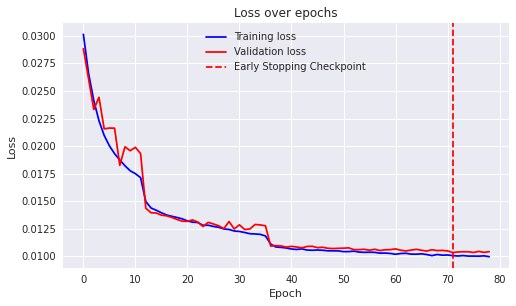

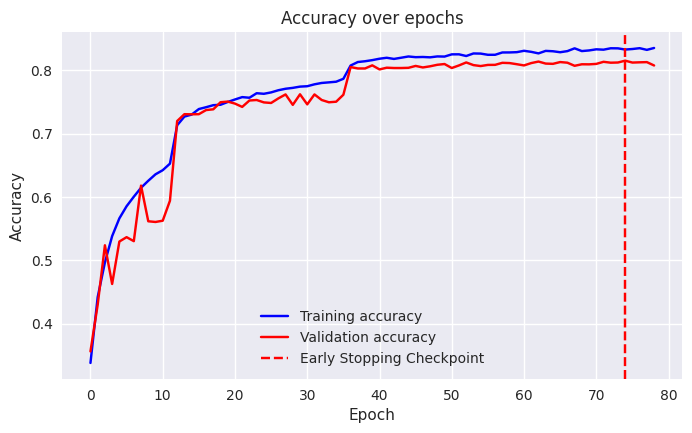

In [19]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'SqueezeNet - predictions')

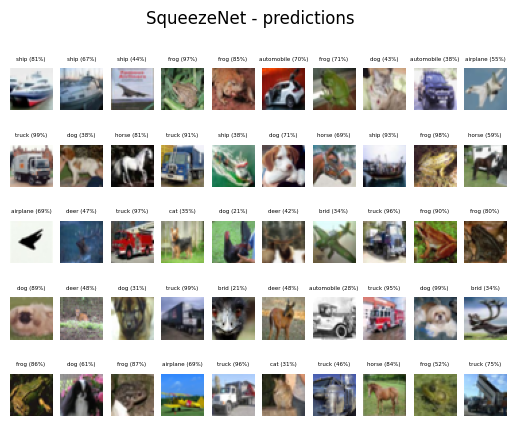

In [20]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('SqueezeNet - predictions')

In [ ]:
"""
SqueezeNet
Mine(batch_size = 32):
After 020 Epoch: 73.4%
After 040 Epoch: 78.8%
After 060 Epoch: 80.3%
After 080 Epoch: 80.7%
After 100 Epoch: 83.2%
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 96, 109, 109]          14,208
       BatchNorm2d-2         [-1, 96, 109, 109]             192
              ReLU-3         [-1, 96, 109, 109]               0
       BasicConv2d-4         [-1, 96, 109, 109]               0
         MaxPool2d-5           [-1, 96, 54, 54]               0
            Conv2d-6           [-1, 16, 54, 54]           1,552
       BatchNorm2d-7           [-1, 16, 54, 54]              32
              ReLU-8           [-1, 16, 54, 54]               0
       BasicConv2d-9           [-1, 16, 54, 54]               0
           Conv2d-10           [-1, 64, 54, 54]           1,088
      BatchNorm2d-11           [-1, 64, 54, 54]             128
             ReLU-12           [-1, 64, 54, 54]               0
      BasicConv2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 64, 54, 54]           9,280
      BatchNorm2d-15           [-1, 64, 54, 54]             128
             ReLU-16           [-1, 64, 54, 54]               0
      BasicConv2d-17           [-1, 64, 54, 54]               0
             Fire-18          [-1, 128, 54, 54]               0
           Conv2d-19           [-1, 16, 54, 54]           2,064
      BatchNorm2d-20           [-1, 16, 54, 54]              32
             ReLU-21           [-1, 16, 54, 54]               0
      BasicConv2d-22           [-1, 16, 54, 54]               0
           Conv2d-23           [-1, 64, 54, 54]           1,088
      BatchNorm2d-24           [-1, 64, 54, 54]             128
             ReLU-25           [-1, 64, 54, 54]               0
      BasicConv2d-26           [-1, 64, 54, 54]               0
           Conv2d-27           [-1, 64, 54, 54]           9,280
      BatchNorm2d-28           [-1, 64, 54, 54]             128
             ReLU-29           [-1, 64, 54, 54]               0
      BasicConv2d-30           [-1, 64, 54, 54]               0
             Fire-31          [-1, 128, 54, 54]               0
           Conv2d-32           [-1, 32, 54, 54]           4,128
      BatchNorm2d-33           [-1, 32, 54, 54]              64
             ReLU-34           [-1, 32, 54, 54]               0
      BasicConv2d-35           [-1, 32, 54, 54]               0
           Conv2d-36          [-1, 128, 54, 54]           4,224
      BatchNorm2d-37          [-1, 128, 54, 54]             256
             ReLU-38          [-1, 128, 54, 54]               0
      BasicConv2d-39          [-1, 128, 54, 54]               0
           Conv2d-40          [-1, 128, 54, 54]          36,992
      BatchNorm2d-41          [-1, 128, 54, 54]             256
             ReLU-42          [-1, 128, 54, 54]               0
      BasicConv2d-43          [-1, 128, 54, 54]               0
             Fire-44          [-1, 256, 54, 54]               0
        MaxPool2d-45          [-1, 256, 26, 26]               0
           Conv2d-46           [-1, 32, 26, 26]           8,224
      BatchNorm2d-47           [-1, 32, 26, 26]              64
             ReLU-48           [-1, 32, 26, 26]               0
      BasicConv2d-49           [-1, 32, 26, 26]               0
           Conv2d-50          [-1, 128, 26, 26]           4,224
      BatchNorm2d-51          [-1, 128, 26, 26]             256
             ReLU-52          [-1, 128, 26, 26]               0
      BasicConv2d-53          [-1, 128, 26, 26]               0
           Conv2d-54          [-1, 128, 26, 26]          36,992
      BatchNorm2d-55          [-1, 128, 26, 26]             256
             ReLU-56          [-1, 128, 26, 26]               0
      BasicConv2d-57          [-1, 128, 26, 26]               0
             Fire-58          [-1, 256, 26, 26]               0
           Conv2d-59           [-1, 48, 26, 26]          12,336
      BatchNorm2d-60           [-1, 48, 26, 26]              96
             ReLU-61           [-1, 48, 26, 26]               0
      BasicConv2d-62           [-1, 48, 26, 26]               0
           Conv2d-63          [-1, 192, 26, 26]           9,408
      BatchNorm2d-64          [-1, 192, 26, 26]             384
             ReLU-65          [-1, 192, 26, 26]               0
      BasicConv2d-66          [-1, 192, 26, 26]               0
           Conv2d-67          [-1, 192, 26, 26]          83,136
      BatchNorm2d-68          [-1, 192, 26, 26]             384
             ReLU-69          [-1, 192, 26, 26]               0
      BasicConv2d-70          [-1, 192, 26, 26]               0
             Fire-71          [-1, 384, 26, 26]               0
           Conv2d-72           [-1, 48, 26, 26]          18,480
      BatchNorm2d-73           [-1, 48, 26, 26]              96
             ReLU-74           [-1, 48, 26, 26]               0
      BasicConv2d-75           [-1, 48, 26, 26]               0
           Conv2d-76          [-1, 192, 26, 26]           9,408
      BatchNorm2d-77          [-1, 192, 26, 26]             384
             ReLU-78          [-1, 192, 26, 26]               0
      BasicConv2d-79          [-1, 192, 26, 26]               0
           Conv2d-80          [-1, 192, 26, 26]          83,136
      BatchNorm2d-81          [-1, 192, 26, 26]             384
             ReLU-82          [-1, 192, 26, 26]               0
      BasicConv2d-83          [-1, 192, 26, 26]               0
             Fire-84          [-1, 384, 26, 26]               0
           Conv2d-85           [-1, 64, 26, 26]          24,640
      BatchNorm2d-86           [-1, 64, 26, 26]             128
             ReLU-87           [-1, 64, 26, 26]               0
      BasicConv2d-88           [-1, 64, 26, 26]               0
           Conv2d-89          [-1, 256, 26, 26]          16,640
      BatchNorm2d-90          [-1, 256, 26, 26]             512
             ReLU-91          [-1, 256, 26, 26]               0
      BasicConv2d-92          [-1, 256, 26, 26]               0
           Conv2d-93          [-1, 256, 26, 26]         147,712
      BatchNorm2d-94          [-1, 256, 26, 26]             512
             ReLU-95          [-1, 256, 26, 26]               0
      BasicConv2d-96          [-1, 256, 26, 26]               0
             Fire-97          [-1, 512, 26, 26]               0
        MaxPool2d-98          [-1, 512, 12, 12]               0
           Conv2d-99           [-1, 64, 12, 12]          32,832
     BatchNorm2d-100           [-1, 64, 12, 12]             128
            ReLU-101           [-1, 64, 12, 12]               0
     BasicConv2d-102           [-1, 64, 12, 12]               0
          Conv2d-103          [-1, 256, 12, 12]          16,640
     BatchNorm2d-104          [-1, 256, 12, 12]             512
            ReLU-105          [-1, 256, 12, 12]               0
     BasicConv2d-106          [-1, 256, 12, 12]               0
          Conv2d-107          [-1, 256, 12, 12]         147,712
     BatchNorm2d-108          [-1, 256, 12, 12]             512
            ReLU-109          [-1, 256, 12, 12]               0
     BasicConv2d-110          [-1, 256, 12, 12]               0
            Fire-111          [-1, 512, 12, 12]               0
         Dropout-112          [-1, 512, 12, 12]               0
          Conv2d-113           [-1, 10, 12, 12]           5,130
     BatchNorm2d-114           [-1, 10, 12, 12]              20
            ReLU-115           [-1, 10, 12, 12]               0
     BasicConv2d-116           [-1, 10, 12, 12]               0
AdaptiveAvgPool2d-117             [-1, 10, 1, 1]               0
         Flatten-118                   [-1, 10]               0
================================================================
Total params: 746,526
Trainable params: 746,526
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 148.75
Params size (MB): 2.85
Estimated Total Size (MB): 152.17
----------------------------------------------------------------
parameters_count: 746526

"""